In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import uuid
from tensorflow.keras.metrics import Precision, Recall

In [2]:
anchor = tf.data.Dataset.list_files('/content/drive/MyDrive/LS_week_4/data/anchor/*.jpg').take(300)
positive = tf.data.Dataset.list_files('/content/drive/MyDrive/LS_week_4/data/positive/*.jpg').take(300)
negative = tf.data.Dataset.list_files('/content/drive/MyDrive/LS_week_4/data/negative/*.jpg').take(300)

In [3]:
dir_test = anchor.as_numpy_iterator()

In [4]:
print(dir_test.next())

b'/content/drive/MyDrive/LS_week_4/data/anchor/564ca303-4a70-11ef-b1c3-ab6a86a1b4f3.jpg'


In [5]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(byte_img)
    image = tf.image.resize(image, (100,100))
    image = image / 255.0
    return image

In [6]:
test_img = preprocess('/content/drive/MyDrive/LS_week_4/data/anchor/57b7640e-4a70-11ef-b743-ab6a86a1b4f3.jpg')

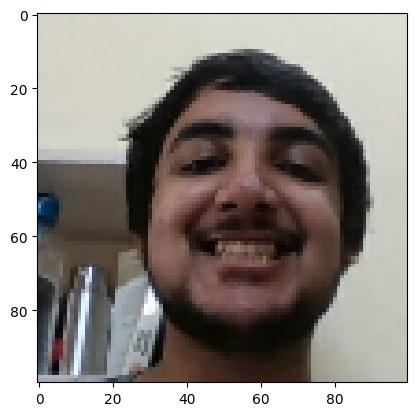

In [7]:
plt.imshow(test_img)

In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
samp_iter = data.as_numpy_iterator()

In [10]:
ex1 = samp_iter.next()

In [11]:
ex1

(b'/content/drive/MyDrive/LS_week_4/data/anchor/619d02e9-4a70-11ef-8ea2-ab6a86a1b4f3.jpg',
 b'/content/drive/MyDrive/LS_week_4/data/positive/4ca5ff9f-4a70-11ef-adde-ab6a86a1b4f3.jpg',
 1.0)

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

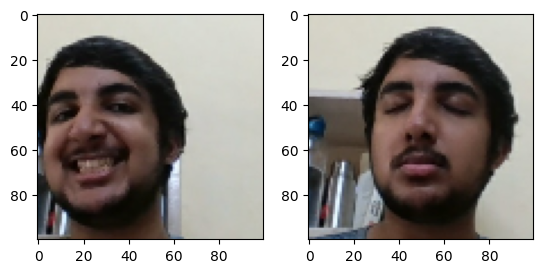

In [13]:
plt.subplot(1,2,1)
plt.imshow(preprocess_twin(*ex1)[0])
plt.subplot(1,2,2)
plt.imshow(preprocess_twin(*ex1)[1])

In [14]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [15]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [16]:
def make_emb():
  inp = Input(shape=(100,100,3), name="input_image")
  c1 = Conv2D(64, (10,10), activation = 'relu')(inp)
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  c2 = Conv2D(128, (7,7), activation = 'relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  c3 = Conv2D(128, (4,4), activation = 'relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation = 'sigmoid')(f1)

  return Model(inputs = [inp], outputs = [d1], name = 'embedding')

In [17]:
emb1 = make_emb()
emb1.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [18]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, ip_emb, val_emb):
        return tf.math.abs(ip_emb - val_emb)

In [19]:
ip_img = Input(name = 'input_img', shape = (100,100,3))
val_img = Input(name = 'validation_img', shape = (100,100,3))
ip_emb = emb1(ip_img)
val_emb = emb1(val_img)

In [20]:
siamese_l = L1Dist()
dist = siamese_l(ip_emb, val_emb)
classifier = Dense(1, activation = 'sigmoid')(dist)

In [21]:
def make_siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(emb1(input_image), emb1(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [22]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [23]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [25]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [26]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        r = Recall()
        p = Precision()
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [27]:
EPOCHS = 40
train(train_data, EPOCHS)


 Epoch 1/40
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 302s 318ms/step
0.32710266 0.24271844 1.0

 Epoch 2/40
27/27 [==============================] - 8s 294ms/step
0.117575385 0.9059406 0.96825397

 Epoch 3/40
27/27 [==============================] - 8s 288ms/step
0.24090473 0.9458128 1.0

 Epoch 4/40
27/27 [==============================] - 8s 309ms/step
0.0050937138 0.9905213 1.0

 Epoch 5/40
27/27 [==============================] - 8s 301ms/step
0.15243238 0.9858491 0.99523807

 Epoch 6/40
27/27 [==============================] - 9s 316ms/step
0.004675634 0.95714283 0.99014777

 Epoch 7/40
27/27 [==============================] - 8s 302ms/step
0.0046363664 0.99509805 1.0

 Epoch 8/40
27/27 [==============================] - 9s 323ms/step
0.007167127 1.0 1.0

 Epoch 9/40
27/27 [==============================] - 9s 317ms/step
0.05735

In [47]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat ]
print(y_hat)
y_true

1/1 [==============================] - 0s 21ms/step
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]


array([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

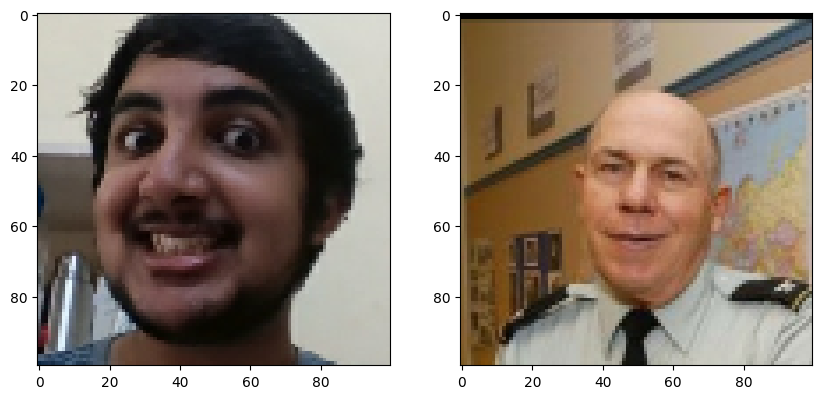

In [49]:
#Different faces
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

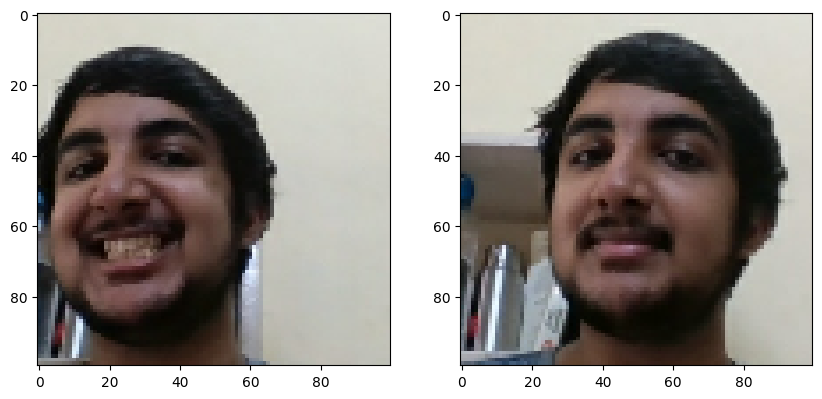

In [52]:
#Same face
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[8])
plt.subplot(1,2,2)
plt.imshow(test_val[8])
plt.show()

In [53]:
m = Recall()
n = Precision()
m.update_state(y_true, y_hat)
n.update_state(y_true, y_hat)
print(m.result().numpy())
print(n.result().numpy())

1.0
1.0


In [54]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 20ms/step
1.0 1.0


In [55]:
siamese_model.save('siamesemodelv2.h5')